# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [1]:
#standard width is ~60%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from scipy import integrate as integ
from scipy.stats import norm
import matplotlib as mpl

# Simple Black-Scholes

In [3]:
def stock_path_BS(S0, t, r, mu, sigma, n_paths, n_steps):
    '''
    Generation of stock paths following Geometeric Brownian motion
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    sigma (float): volatility
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simulated stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
        
    #Time increment between each step, needs to match proper shape
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    #paths
    paths = S0*np.exp(log_returns)
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

## Discrete volatility distribution

In [4]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simulated stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

## Heston Model

In [5]:
def stock_path_heston_model(S0, t, r, mu, n_paths, n_steps,
                            nu_0=0.5, theta=0.3, rho=0.1, kappa=5, xi=0.01, scale=1):
    '''
    Generation of custom stock paths following the Heston model
    
    Each step of the stock path is given through a stochastic process
    which looks structurally similar to gerometric brownian motion in stock
    path, but also has a stochastic volatility which follows a Wiener process
    with a mean reversion drift rate.
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    scale (int): an intraday scale that helps reduce flatness of S_T, can be seen as reducing dt
    
    + Heston Input:
    nu_0: initial variance
    theta: "long term" or "mean" variance
    rho: normal correlation between S and sigma
    kappa: mean reversion rate or "drift rate"
    xi: volatility of volatility; stability criterion: 2*kappa*theta > xi

    Returns:
    
    Simulated stock paths
    Simulated volatility paths
    '''
    if xi*xi >= 2*kappa*theta and xi!=0:
        print("Invalid values of xi, kappa, theta. Returning NaN.")
        print("xi*xi={}".format(xi*xi))
        print("2*kappa*theta={}".format(2*kappa*theta))
        return float('nan')
    
    n_steps = int(n_steps*scale)
    
    #We need to generate a correlation between nu_T and S_T using the intermediate variable Z
    N_nu = np.random.normal(0,1,size = (n_paths, n_steps))
    Z = np.random.normal(0,1,size = (n_paths, n_steps))
    N_S = rho*N_nu + np.sqrt(1-rho**2)*Z

    #Create the space for the arrays and store the initial value
    nu_T = np.zeros((n_paths, n_steps + 1))
    S_T = np.zeros((n_paths, n_steps + 1))
    
    nu_T[:,0] = nu_0
    S_T[:,0] = S0
    
    #time step size followed by the Heston evoution equations
    dt = t/n_steps
    for i in range(n_steps):
        nu_prev, S_prev = np.maximum(nu_T[:,i],0), S_T[:,i]
        sqrt_nu_prev = np.sqrt(np.maximum(nu_prev, 0))
        
#         nu_T[:,i+1] = np.maximum(nu_prev + kappa*(theta-nu_prev)*dt + xi*np.sqrt(nu_prev)*N_nu[:,i],0)
#         nu_T[:,i+1] = nu_prev + kappa*(theta-nu_prev)*dt + xi*np.sqrt(nu_prev)*N_nu[:,i]
        nu_T[:,i+1] = nu_prev + kappa*(theta-nu_prev)*dt + xi*sqrt_nu_prev*N_nu[:,i]
        nu_T[:,i+1] = np.maximum(nu_T[:,i+1], 0) 
        
        S_T[:,i+1] = S_prev*np.exp((mu + r - 0.5*nu_prev)*dt + sqrt_nu_prev*np.sqrt(dt)*N_S[:,i])
        
        #with "truncation" on negative nu_T
#         S_T[:,i+1] = S_prev*np.exp((mu + r - 0.5*nu_prev)*dt + np.sqrt(nu_prev*dt)*N_S[:,i])


#     for i in range(n_steps):
#         vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
#                                 xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
#         paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
#                                                np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
        
    return S_T[:,::scale], nu_T[:,::scale]
    
    

## ARMA-GARCH

In [6]:
def stock_path_ARMA_GARCH(S0, nu0, arma_params, garch_params, S_mean, Var_mean, n_paths, n_steps):
    '''
    Generation of custom stock paths following ARMA with GARCH residuals
    That is, an ARMA(p,q)+GARCH(r,s) process.
    **Note: we enforce that r = max(q,s), or function bails so there is no ambiguity.**
    
    Each step of the stock path is given through a stochastic process
    where the mean dynamics follow an ARMA process and the volatility
    of the path is given by a GARCH process
    
    Inputs:
    -S0 (float [array]): array like object, initial stock value(s), length should be equal to p
    -nu0 (float [array]): array like object, initial variance(s), length should be equal to r
    
    -arma_params (float [array]): tuple containing two array-like objects, the lengths of which are p and q,
    respectively. 0th array for AR params, 1st array for MA params.
    
    -garch_params (float [array]): tuple containing two array-like objects, the lengths of which are p and q,
    respectively. 0th array for AR params, 1st array for CH params.
    
    - S_mean (float): Mean of stock price, used to calculate mu, the ARMA parameter
    - Var_mean (float): Mean of variance, used to calulate omega, the GARCH parameter
    
    -n_paths (int): number of stock paths
    -n_steps (float): number of steps in each stock path

    Returns:
    
    Simulated stock paths
    Simulated volatility paths
    '''
    AR_params = np.atleast_1d(arma_params[0])
    MA_params = np.atleast_1d(arma_params[1])
    AR_var_params = np.atleast_1d(garch_params[0])
    ch_params = np.atleast_1d(garch_params[1])
    
    mu = S_mean*(1-np.sum(AR_params))
    omega = Var_mean*(1-np.sum(AR_var_params + ch_params))
    
    S0 = np.atleast_1d(S0)
    nu0 = np.atleast_1d(nu0)
    
    #There are p AR paramters that get coupled with p initial stock values
    #There are q MA_parameters that get coupled with q initial variance
    p,q = len(AR_params),len(MA_params)
    #There are r AR_vol parameters that get coupled with r initial variances
    #There are s CH parameters that get coupled with s initial normal errors
    r,s = len(AR_var_params),len(ch_params)

    if len(S0) != p or (len(nu0) != r and r!= max(q,s)) :
        print("Parameter mismatch in lengths. Lengths of input must be consistent.")
        return float('nan')
        
    Z = np.random.normal(0,1,size = (n_paths, n_steps + r))
    
    #Create the space for the arrays and store the initial value
    nu_T = np.zeros((n_paths, n_steps + r))
    S_T = np.zeros((n_paths, n_steps + p))
    #remember python is non-inclusive end slicing
    nu_T[:,0:r] = nu0
    S_T[:,0:p] = S0
    
    for i in range(n_steps):
        nu_prev, S_prev = nu_T[:,i:i+r], S_T[:,i:i+p]
        vareps_prev = np.sqrt(nu_prev)*Z[:,i:i+r]
        
        nu_T[:,i+r] = omega + np.sum(AR_var_params*nu_prev,axis=1) +\
                                        np.sum(ch_params*(vareps_prev*vareps_prev),axis=1)
        
        vareps_t = np.sqrt(nu_T[:,i+1])*Z[:,i+1]
        S_T[:,i+r] = mu + np.sum(AR_params*S_prev,axis=1) + np.sum(MA_params*vareps_prev,axis=1)
        
    return S_T, nu_T
    
    

## Heston-Nandi GARCH -- (1,1) Model

In [7]:
def stock_path_heston_nandi(S0, h0, t, mu, r, Var_mean, beta, alpha, gamma, n_paths, n_steps,scale=1, lam=-1/2):
    '''
    Generation of custom stock paths following Heston-Nandi Garch (1,1) 
    
    ((  Heston, Steven L. and Nandi, Saikat, A Closed-Form GARCH Option Valuation Model.
    Available at SSRN: https://ssrn.com/abstract=210009 or http://dx.doi.org/10.2139/ssrn.210009  ))
    
    This is a GARCH(1,1) process, where the mean (Stock price) dynamics are given by something
    structurally similar to Black-Scholes model, Heston model, etc
    
    Inputs: (loosley following notation from paper)
    -S0 (float): inital stock value
    -h0 (float): initial variance
    -mu (float): drift of log returns
    -r (float): risk free rate
    - Var_mean (float): Mean of variance, used to calulate omega, the GARCH parameter
    -beta (float): GARCH mean reversion parameter for variance
    -alpha (float): GARCH error influence parameter (moving average) for variance
    -lam (float): lambda in the Heston-Nandi paper, "market price of risk", set to -1/2 for risk neutral
    -gamma (float): "asymmetric influence", extra GARCH parameter which influeces moving average for variance
    
    - S_mean (float): Mean of stock price, used to calculate mu, the ARMA parameter
    - Var_mean (float): Mean of variance, used to calulate omega, the GARCH parameter
    
    -n_paths (int): number of stock paths
    -n_steps (float): number of steps in each stock path
    
    scale (int): an intraday scale that helps reduce flatness of S_T, can be seen as reducing dt

    Returns:
    
    Simulated stock paths
    Simulated volatility paths
    '''
    
    n_steps = n_steps*scale
    #GARCH parameters also need to be rescaled
    alpha /= scale
    beta /= scale
    
    #converting from mean varaince to haston-nandi GARCH omega
    omega = Var_mean*(1 - beta - alpha*(1 + gamma*gamma))
    
    #following notation of the paper, z is the noise at time t
    z = np.random.normal(0,1,size = (n_paths,n_steps))

    #set arrays
    h_T = np.zeros((n_paths, n_steps + 1))
    S_T = np.zeros((n_paths, n_steps + 1))
    h_T[:,0] = h0
    S_T[:,0] = S0
    
    dt = t/n_steps
    for i in range(n_steps):
        h_prev, S_prev = h_T[:,i], S_T[:,i]
        
        h_T[:,i+1] = omega + beta*h_prev + alpha*(z[:,i] - gamma*np.sqrt(h_prev))**2
        var_T = h_T[:,i+1]
        #KEY DIFFERENCE BETWEEN THIS AND HESTON: S-T CALCULATED FROM **CURRENT** VOLATILITY
        S_T[:,i+1] = S_prev*np.exp((mu + r - lam*var_T)*dt + np.sqrt(var_T*dt)*z[:,i])
        
    return S_T[:,::scale], h_T[:,::scale]
        
    
    

## Standard Black-Scholes Simulations

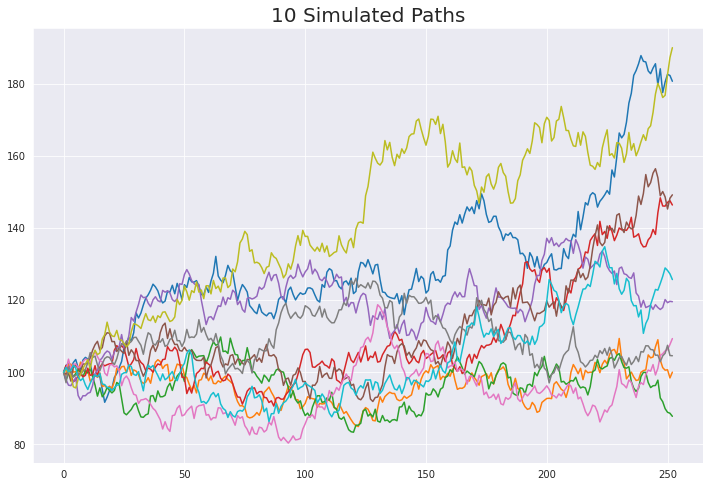

In [8]:
S0 = 100
t = 1
r = 0.039
mu = 0.275
sigma = 0.3
n_paths = 10
n_steps = 252

simulated_paths = stock_path_BS(S0, t, r, mu, sigma, n_paths, n_steps)

plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths', size = 20)


plt.show()

# Discrete distribution simulations

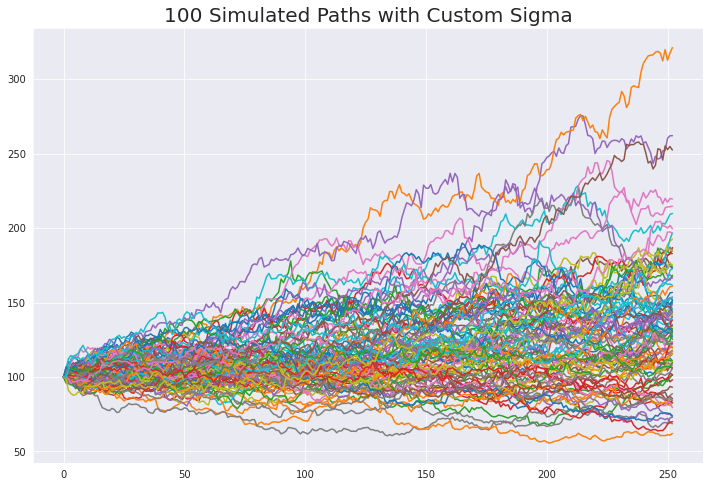

In [9]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 100
n_steps = 252

simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

# Heston Simulations

- Same parameters a previous exampe
- New Heston paramters; simulation is best behaved when $\xi$ is small
- Heston path sampler checks for **Feller condition**, although my understanding is that sometimes people do purposefully run simulations that don't meet this criterion.
- Still not sure if the best way to handle nu_T<0 is to use the max function:

        ... np.sqrt(np.maximum(nu_prev, 0)*dt)*N_S[:,i])
        
- Why not rejection sampling? Or [Quadratic Exponential method from Anderson](http://www.ressources-actuarielles.net/EXT/ISFA/1226.nsf/0/1826b88b152e65a7c12574b000347c74/$FILE/LeifAndersenHeston.pdf)

Text(0, 0.5, 'Variance, $\\nu(t)$')

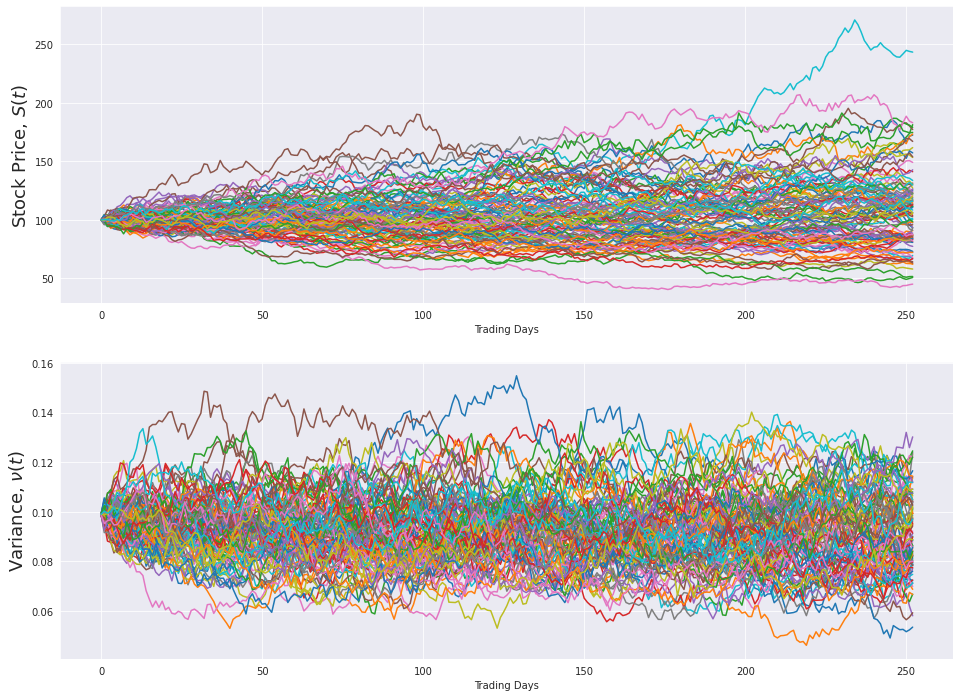

In [10]:
kappa = 5
theta = .3**2
xi = 0.01
nu_0 = theta*(1+0.1)
rho = 0.5
S0 = 100
t = 1
n_steps = 252
r = 0.04
n_paths = 100
dt = t / n_steps
mu = .06
scale = 1

S_T, nu_T = stock_path_heston_model(S0, t, r, mu, n_paths, n_steps, nu_0, theta, rho, kappa, xi, scale)

fig, (ax_S,ax_nu) = plt.subplots(2,1,figsize=(16,12))
for i,path in enumerate(S_T):
    ax_S.plot(path)
    ax_nu.plot(nu_T[i,:])
    
ax_S.set_xlabel("Trading Days")
ax_S.set_ylabel(r"Stock Price, $S(t)$",fontsize=18)
ax_nu.set_xlabel("Trading Days")
ax_nu.set_ylabel(r"Variance, $\nu(t)$",fontsize=18)

# ARMA-GARCH simulations
- ARMA(1,1) GARCH(1,1)
- These simulations don't look much like actualy stock paths, however the volatility spikes may be a useful feature to include in a better model
- Obviously, these are also not risk neutral measure distributions, which is required to price traditional options in the absence of arbitrage

Text(0, 0.5, 'Variance, $\\nu(t)$')

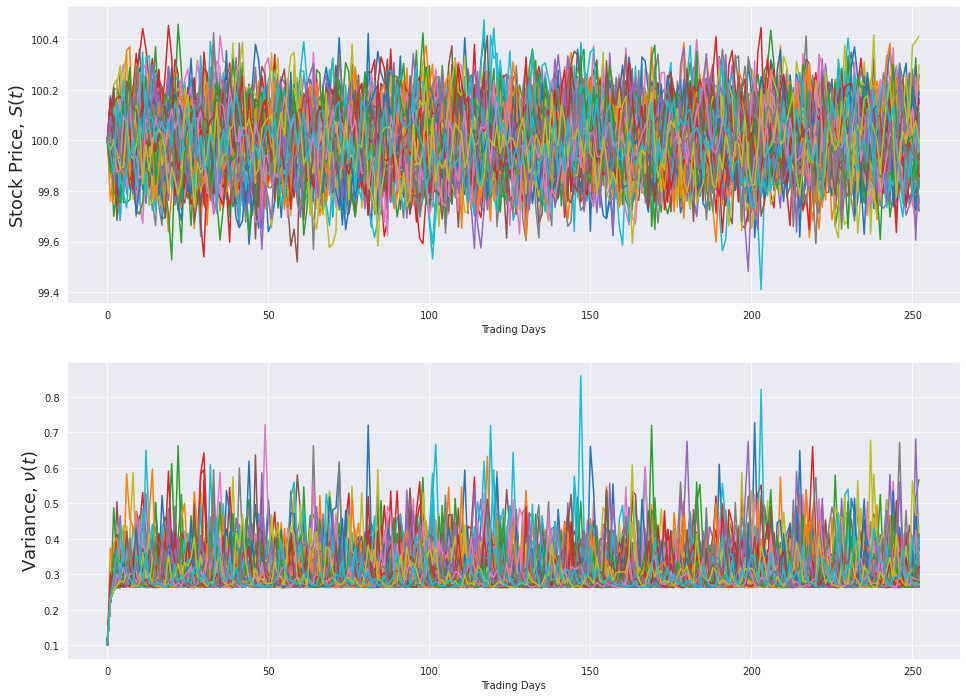

In [11]:
S0 = 100
nu0 = 0.1
arma_params = (0.4,0.2)
garch_params = (0.2,0.1)
S_mean = 100
Var_mean = 0.3
n_paths = 100
n_steps = 252
S_T, nu_T = stock_path_ARMA_GARCH(S0, nu0, arma_params, garch_params, S_mean, Var_mean, n_paths, n_steps)

fig, (ax_S,ax_nu) = plt.subplots(2,1,figsize=(16,12))
for i,path in enumerate(S_T):
    ax_S.plot(path)
    ax_nu.plot(nu_T[i,:])
    
ax_S.set_xlabel("Trading Days")
ax_S.set_ylabel(r"Stock Price, $S(t)$",fontsize=18)
ax_nu.set_xlabel("Trading Days")
ax_nu.set_ylabel(r"Variance, $\nu(t)$",fontsize=18)

## Heston-Nandi Simulations
- These look way more realistic that the ARMA-GARCH model due to the log return nature
- This model also features **volatility clustering**, a feature not seen in the Heston model
- Heston and Nandi give a closed form solution for option pricing

Text(0, 0.5, 'Variance, $\\nu(t)$')

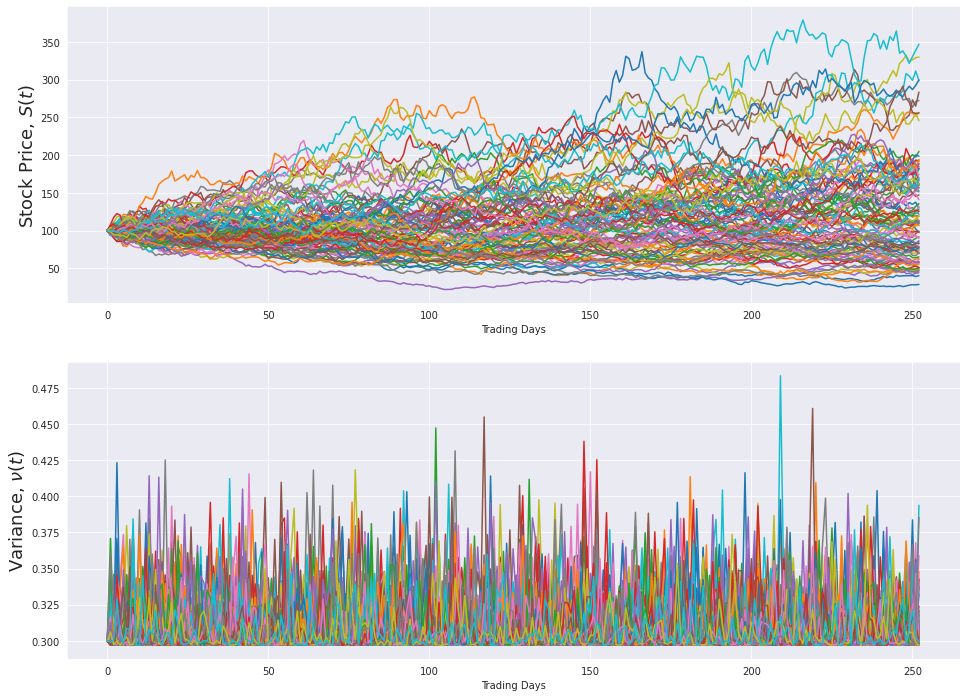

In [12]:
S0 = 100
t = 1
r = 0.039
mu = 0
h0 = 0.3
Var_mean = 0.3
beta = 0.1
alpha = 0.1
gamma = 0.1

n_paths = 100
n_steps = 252
scale = 10

S_T, nu_T = stock_path_heston_nandi(S0, h0, t, mu, r, Var_mean, beta, alpha, gamma, n_paths, n_steps, scale)

fig, (ax_S,ax_nu) = plt.subplots(2,1,figsize=(16,12))
for i,path in enumerate(S_T):
    ax_S.plot(path)
    ax_nu.plot(nu_T[i,:])
    
ax_S.set_xlabel("Trading Days")
ax_S.set_ylabel(r"Stock Price, $S(t)$",fontsize=18)
ax_nu.set_xlabel("Trading Days")
ax_nu.set_ylabel(r"Variance, $\nu(t)$",fontsize=18)

# Volatility Smiles

### Black-Scholes: Classic Option Pricing

In [13]:
def BS_Call(S,K,sigma,t,r):
    d_plus = ( np.log(S/K) + (r + sigma*sigma/2)*t )/(sigma*np.sqrt(t))
    d_minus = d_plus - sigma*np.sqrt(t)
    return S*norm.cdf(d_plus) - K*np.exp(-r*t)*norm.cdf(d_minus)

def BS_Delta(S,K,sigma,t,r):
    d_plus = (1/(sigma*np.sqrt(t)))*( np.log(S/K) + (r + sigma*sigma/2)*t )
    return norm.cdf(d_plus)

In [14]:
# We take the following function from functions.py in the bootcamp github page
from scipy.optimize import brentq
def implied_volatility_call(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a call option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return BS_Call(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan

### Calculate Analogous Paths

In [15]:
S0 = 100
t = 1
r = 0.04
###################################################################################################################
## HESTON NANDI ##
mu = 0
h0 = 0.3
Var_mean = 0.3**2
beta = 0.1
alpha = 0.1
gamma = 0.1

n_paths = 1000
n_steps = 50
scale = 10

S_T_HN, nu_T_HN = stock_path_heston_nandi(S0, h0, t, mu, r, Var_mean, beta, alpha, gamma, n_paths, n_steps, scale)
###################################################################################################################
## ARMA GARCH ##
nu0 = 0.1
arma_params = (0.1,0.1)
garch_params = (0.3,0.3)
Var_mean = 0.3**2

S_T_AG, nu_T_AG = stock_path_ARMA_GARCH(S0, nu0, arma_params, garch_params, S_mean, Var_mean, n_paths, n_steps)
###################################################################################################################
## HESTON ##
kappa = 5
theta = .3**2
xi = 0.01
nu_0 = theta*(1+0.1)
rho = 0.5
r = 0.04
dt = t / n_steps
mu = .06
scale = 1

S_T_H, nu_T_H = stock_path_heston_model(S0, t, r, mu, n_paths, n_steps, nu_0, theta, rho, kappa, xi, scale)
###################################################################################################################

### Calculate Option Prices

In [16]:
strikes = range(int(.6*S0), int(1.4*S0))

S_f_HN, S_f_AG, S_f_H = S_T_HN[:, -1], S_T_AG[:, -1], S_T_H[:, -1]

call_dict_HN = {K: np.mean(np.maximum(S_f_HN - K, 0)) * np.exp(-r * t) for K in strikes}
call_dict_AG = {K: np.mean(np.maximum(S_f_AG - K, 0)) * np.exp(-r * t) for K in strikes}
call_dict_H = {K: np.mean(np.maximum(S_f_H - K, 0)) * np.exp(-r * t) for K in strikes}


# Compute implied vols
implied_vol_HN = {K: implied_volatility_call(call_dict_HN[K], S0, K, t, r) for K in strikes}
implied_vol_AG = {K: implied_volatility_call(call_dict_AG[K], S0, K, t, r) for K in strikes}
implied_vol_H = {K: implied_volatility_call(call_dict_H[K], S0, K, t, r) for K in strikes}

### Say cheese!

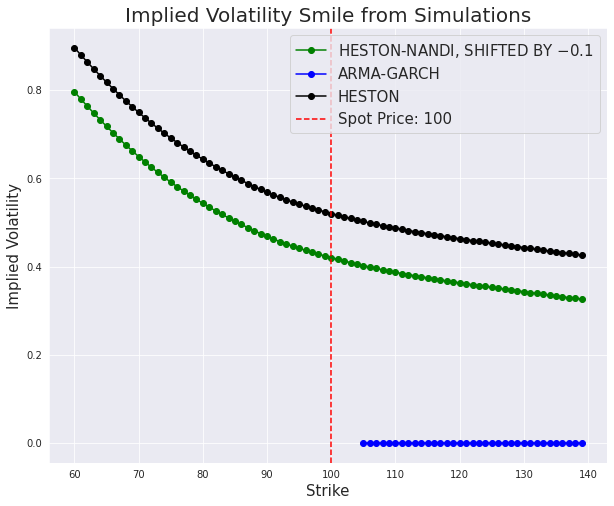

In [17]:
plt.figure(figsize = (10,8))
plt.plot(list(implied_vol_HN.keys()), np.array(list(implied_vol_HN.values()))-0.1, marker='o', color='g', label=r'HESTON-NANDI, SHIFTED BY $-0.1$')
plt.plot(list(implied_vol_AG.keys()), list(implied_vol_AG.values()), marker='o', color='b', label='ARMA-GARCH')
plt.plot(list(implied_vol_HN.keys()), list(implied_vol_HN.values()), marker='o', color='k', label='HESTON')
plt.xlabel("Strike", size = 15)
plt.ylabel("Implied Volatility", size = 15)
plt.title("Implied Volatility Smile from Simulations", size = 20)
plt.axvline(S0, label= f'Spot Price: {S0}', color = 'red', linestyle='--')

plt.legend(fontsize = 15)
plt.show()

## Comments:   
    - Heston-Nandi and Heston Model have the same implied volatility. Here we shift by -0.1 so it is possible to see both smiles. This is expected since Heston-Nandi converges to Heston in the continuous limit
    - ARMA-GARCH is not a good model for pricing. The root finder struggled to find solutions for more than half    of the strikes, and plateaued at the lower limit for those that it found.  
    This is most likely related to ARMA_GARCH not being a matingale i.e not risk neutral.
    
### From here on we focus on the Heston Model

# Heston Model Option Pricing: Closed Form Solution

*used* https://arxiv.org/pdf/1502.02963 *as a reference for the formulas (not the code)*   
*can also be fund in* https://arxiv.org/pdf/1511.08718 *in Eq. 12*

In [18]:
#Characteristic function for the closed form Heston Solution
def Heston_Characteristic(w,S0,t,rho,r,nu0,xi,kappa,theta):
    I = 1j
    a = -w*w/2 - I*w/2
    b = kappa - rho*xi*I*w
    gamma = xi*xi/2
    h = np.sqrt(b*b - 4*a*gamma)
    rP = (b+h)/(xi*xi)
    rM = (b-h)/(xi*xi)
    g = rM/rP
    D = rM*( 1-np.exp(-h*t) )/( 1-g*np.exp(-h*t) )
    C = kappa*( rM*t - (2/(xi*xi))*np.log( (1-g*np.exp(-h*t))/(1-g) ) )
    return np.exp( C*theta + D*nu0 + I*w*(np.log(S0)+ r*t) )

#little pi_1, i.e. the density in w and thus unintegrated
def pi_1(w,S0,K,t,rho,r,nu0,xi,kappa,theta):
    I = 1j
    psiN = Heston_Characteristic(w-I,S0,t,rho,r,nu0,xi,kappa,theta)
    psiD = Heston_Characteristic(-I,S0,t,rho,r,nu0,xi,kappa,theta)
    numerator = np.exp(-I*w*np.log(K))*psiN
    denom = I*w*psiD
    return np.real(numerator/denom)

#little pi_2, i.e. the density in w and thus unintegrated
def pi_2(w,S0,K,t,rho,r,nu0,xi,kappa,theta):
    I = 1j
    psiN = Heston_Characteristic(w,S0,t,rho,r,nu0,xi,kappa,theta)
    numerator = np.exp(-I*w*np.log(K))*psiN
    denom = I*w
    return np.real(numerator/denom)

def Heston_Call_Option(S0,K,t,rho,r,nu0,xi,kappa,theta,works=1):
    int_PI_1, err1 = integ.quad_vec(pi_1, 0, np.inf, workers = works, args=(S0,K,t,rho,r,nu0,xi,kappa,theta))
    int_PI_2, err2 = integ.quad_vec(pi_2, 0, np.inf, workers = works, args=(S0,K,t,rho,r,nu0,xi,kappa,theta))
    return S0*(0.5 + int_PI_1/np.pi) - K*np.exp(-r*t)*(0.5 + int_PI_2/np.pi)

#Delta greek for the Heston model
#This can be derived by realizing that the call price is a 1st order homogeneous function
# of the stock price S and strike price K
def Heston_Delta(S0,K,t,rho,r,nu0,xi,kappa,theta,works=1):
    int_PI_1, err1 = integ.quad_vec(pi_1, 0, np.inf, workers = works, args=(S0,K,t,rho,r,nu0,xi,kappa,theta))
    return (0.5 + int_PI_1/np.pi)

#The derivative of the characteristic with respect to v0 brings down a factor of D
#This factor of D requires most of the definitions made in the characteristic function
#function. So instead of invoking the function, we just also define C and do the
#characteristic function here
def Dpi_2_Dv0(w,S0,K,t,rho,r,nu0,xi,kappa,theta):
    I = 1j
    a = -w*w/2 - I*w/2
    b = kappa - rho*xi*I*w
    gamma = xi*xi/2
    h = np.sqrt(b*b - 4*a*gamma)
    rP = (b+h)/(xi*xi)
    rM = (b-h)/(xi*xi)
    g = rM/rP
    D = rM*( 1-np.exp(-h*t) )/( 1-g*np.exp(-h*t) )
    C = kappa*( rM*t - (2/(xi*xi))*np.log( (1-g*np.exp(-h*t))/(1-g) ) )
    psi = np.exp( C*theta + D*nu0 + I*w*(np.log(S0)+ r*t) )

    numerator = np.exp(-I*w*np.log(K))*psi*D
    denom = I*w
    return np.real(numerator/denom)

#Vega greek for the Heston Model, differentiation with respect to instantaneous volatility
def Heston_Vega_1(S0,K,t,rho,r,nu0,xi,kappa,theta,works=1):
    int_Vega_1, err = integ.quad_vec(Dpi_2_Dv0, 0, np.inf, workers = works, args=(S0,K,t,rho,r,nu0,xi,kappa,theta))
    return -2*np.sqrt(nu0)*(K/np.pi)*np.exp(-r*t)*int_Vega_1

#The control variant of the Heston model is not Delta, but instead a combination of
#Delta and Vega_1 .. This can be derived from a portfolio variance minimization calculation
def Heston_Control_Variant(S0,K,t,rho,r,nu0,xi,kappa,theta,works=1):
    if np.isclose(rho,0) or np.isclose(xi,0):
        return Heston_Delta(S0,K,t,rho,r,nu0,xi,kappa,theta,works)
    else:
        return Heston_Delta(S0,K,t,rho,r,nu0,xi,kappa,theta,works) + (rho*xi/S0)*Heston_Vega_1(S0,K,t,rho,r,nu0,xi,kappa,theta,works)
    
def D2pi_1_DS2(w,S0,K,t,rho,r,nu0,xi,kappa,theta):
    I = 1j
    psiN = Heston_Characteristic(w-I,S0,t,rho,r,nu0,xi,kappa,theta)
    psiD = Heston_Characteristic(-I,S0,t,rho,r,nu0,xi,kappa,theta)
    numerator = np.exp(-I*w*np.log(K))*psiN
    return np.real(numerator/psiD)

#Gamma greek for the heston model, double differentiated with respect to S
def Heston_Gamma(S0,K,t,rho,r,nu0,xi,kappa,theta,works=1):
    int_Gamma, err = integ.quad_vec(D2pi_1_DS2, 0, np.inf, workers = works, args=(S0,K,t,rho,r,nu0,xi,kappa,theta))
    return int_Gamma/(np.pi*S0)


#2-call Delta-Vega Hedge
def Delta_Vega_2Call_Hedge(S0,K_tuple,t,rho,r,nu0,xi,kappa,theta,works=1):
    '''
    Control variates of hedging a sold call with a bought call and purchase of underlying
    The strategy associated with these control variates assumes you can buy and sell calls
    for any K at any time for any price. Not necessarily realistic.
    Perhaps there is another interprestion in which you buy puts when you need to sell calls.
    This might be easier in practice but still not that realistic.
    
    ((  Reference for derivation is Neely paper referenced under hedgin section later in notebook  ))
    
    This is a hedging process which requires e.g. selling a call of an underlying, buying the underlying, and
    buying a different call of the underlying.
    
    Inputs:
    
    -S0 (float): inital stock values
    -K_tuple (tuple of floats): strike prices STRUCTURED (first call, second call)
    -t (float): time horizon
    -rho (float): correlation between volatalities and respective underlying prices
    -r (float): risk free rate
    -nu0 (float): initial variance
    -kappa (float): mean reversion rate or "drift rate"
    -theta (float): "long term" or "mean" variance

    Returns:
    Tuple of control variants, first for the underlying and second for the bought call
    '''
    K_1, K_2 = K_tuple
    
    delta_call_1 = Heston_Delta(S0,K_1,t,rho,r,nu0,xi,kappa,theta,works)
    delta_call_2 = Heston_Delta(S0,K_2,t,rho,r,nu0,xi,kappa,theta,works)
    vega_call_1 = Heston_Vega_1(S0,K_1,t,rho,r,nu0,xi,kappa,theta,works)
    vega_call_2 = Heston_Vega_1(S0,K_2,t,rho,r,nu0,xi,kappa,theta,works)

    cv_underlying = delta_call_2*( vega_call_1/vega_call_2 ) - delta_call_1
    cv_call_2 = -vega_call_1/vega_call_2
    
    return cv_underlying,cv_call_2


### We can compare the Call prices and their associated Deltas between Heston and Black-Scholes

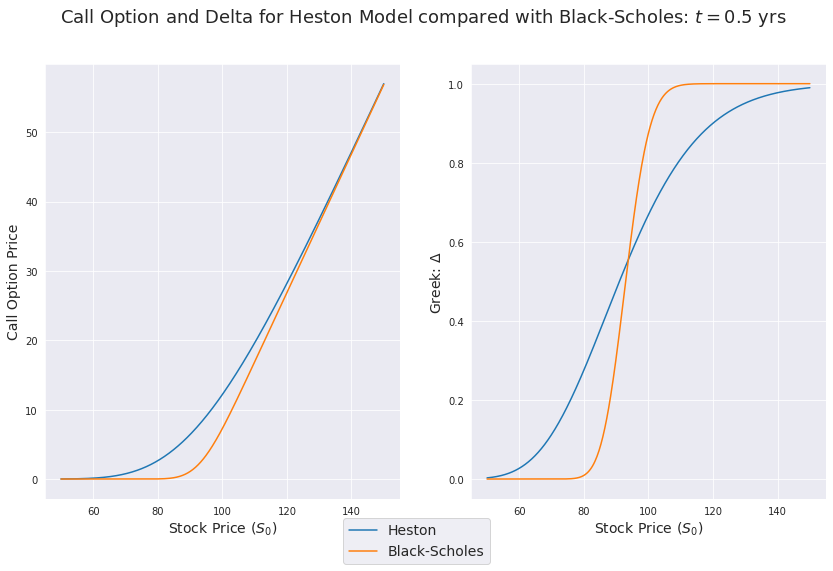

In [19]:
S0 = np.linspace(50,150,500)
K = 95
kappa = 5
theta = .3**2
xi = 0.01
nu_0 = theta*(1+0.1)
rho = 0.5
r = 0.04
t = 0.5

sigma = theta

C = Heston_Call_Option(S0,K,t,rho,r,nu_0,xi,kappa,theta)
Delta = Heston_Delta(S0,K,t,rho,r,nu_0,xi,kappa,theta)

BS_C = BS_Call(S0,K,sigma,t,r)
BS_D = BS_Delta(S0,K,sigma,t,r)

fig, axs = plt.subplots(1,2,figsize=(14,8))
axs[0].plot(S0,C,label='Heston')
axs[0].plot(S0,BS_C,label='Black-Scholes')
axs[0].set_xlabel(r"Stock Price ($S_0$)",fontsize=14)
axs[0].set_ylabel("Call Option Price",fontsize=14)
axs[1].plot(S0,Delta)
axs[1].plot(S0,BS_D)
axs[1].set_xlabel(r"Stock Price ($S_0$)",fontsize=14)
axs[1].set_ylabel(r"Greek: $\Delta$",fontsize=14)

fig.suptitle(r"Call Option and Delta for Heston Model compared with Black-Scholes: $t={}$ yrs".format(t),fontsize=18)
fig.legend(loc='lower center',fontsize=14)
plt.show()

### In fact we can compare across $S_0$ and $t$

In [20]:
S0 = np.linspace(0.01,300,300)
K = 95
kappa = 5
theta = .3**2
xi = 0.01
nu_0 = theta*(1+0.1)
rho = 0.5
r = 0.04
t = np.linspace(0.001,5,100)

sigma = theta

C = np.array([Heston_Call_Option(S0,K,tt,rho,r,nu_0,xi,kappa,theta,works=-1) for tt in t])
Delta = np.array([Heston_Delta(S0,K,tt,rho,r,nu_0,xi,kappa,theta,works=-1) for tt in t])
BS_C = np.array([BS_Call(S0,K,sigma,tt,r) for tt in t])
BS_D = np.array([BS_Delta(S0,K,sigma,tt,r) for tt in t])

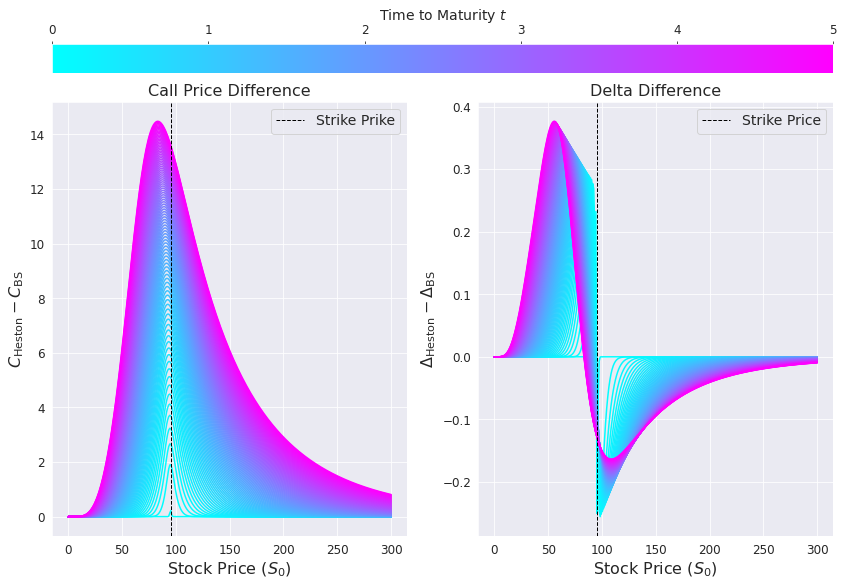

In [21]:
# Compute differences
Dif_C = (C - BS_C) 
Dif_D = (Delta - BS_D)

# Set up figure and axes
fig, (axC, axD) = plt.subplots(1, 2, figsize=(14, 8))
cmap = mpl.cm.get_cmap('cool')
norm_mpl = mpl.colors.Normalize(vmin=0, vmax=np.amax(t), clip=False)

#color code time horizons
for i, ti in enumerate(t):
    color = cmap(norm_mpl(ti))
    axC.plot(S0, Dif_C[i], color=color, linewidth=1.5)
    axD.plot(S0, Dif_D[i], color=color, linewidth=1.5)
axC.axvline(K, color='k', linewidth=1., linestyle="--",label='Strike Prike')
axD.axvline(K, color='k', linewidth=1., linestyle="--",label='Strike Price')
axC.legend(loc='upper right',fontsize=14)
axD.legend(loc='upper right',fontsize=14)

# Style axes
axC.set_xlabel(r'Stock Price ($S_0$)', fontsize=16)
axC.set_ylabel(r'$C_\mathrm{Heston} - C_\mathrm{BS}$', fontsize=16)
axC.tick_params(labelsize=12)
axC.set_title("Call Price Difference", fontsize=16)

# axD.hlines(y=0, xmin=S0.min(), xmax=S0.max(), color='k', linestyle='--', linewidth=1.5)
axD.set_xlabel(r'Stock Price ($S_0$)', fontsize=16)
axD.set_ylabel(r'$\Delta_\mathrm{Heston} - \Delta_\mathrm{BS}$', fontsize=16)
axD.tick_params(labelsize=12)
axD.set_title("Delta Difference", fontsize=16)

# # Custom colorbar axis above plots
xMinPos = axC.get_position().x0
yMinPos = axC.get_position().y1 + 0.05
xWidth = axD.get_position().x1 - axC.get_position().x0
yWidth = 0.05
cax = fig.add_axes([xMinPos, yMinPos, xWidth, yWidth])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_mpl)
cax.grid(False)
fig.colorbar(sm, cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cax.tick_params(labelsize=12)
cax.set_xlabel(r'Time to Maturity $t$', fontsize=14)

plt.show()

## As we can see, they differ substantially
- They differ the most around the strike price for all times
- They differ the most for any $S_0$ at long times until maturity
- There is an asymmetry around the strike price (this is probably the same asymmetry which shows up in the volatility smile)

# It might be more fair to compare control variates instead of deltas

In [22]:
# S0 = np.linspace(0.01,300,300)
# K = 95
# kappa = 5
# theta = .3**2
# xi = 0.01
# nu_0 = theta*(1+0.1)
# rho = 0.5
# r = 0.04
# t = np.linspace(0.001,5,100)

#Use same paramters from last cell for fairest comparison
Cntr_Var = np.array([Heston_Control_Variant(S0,K,tt,rho,r,nu_0,xi,kappa,theta,works=-1) for tt in t])


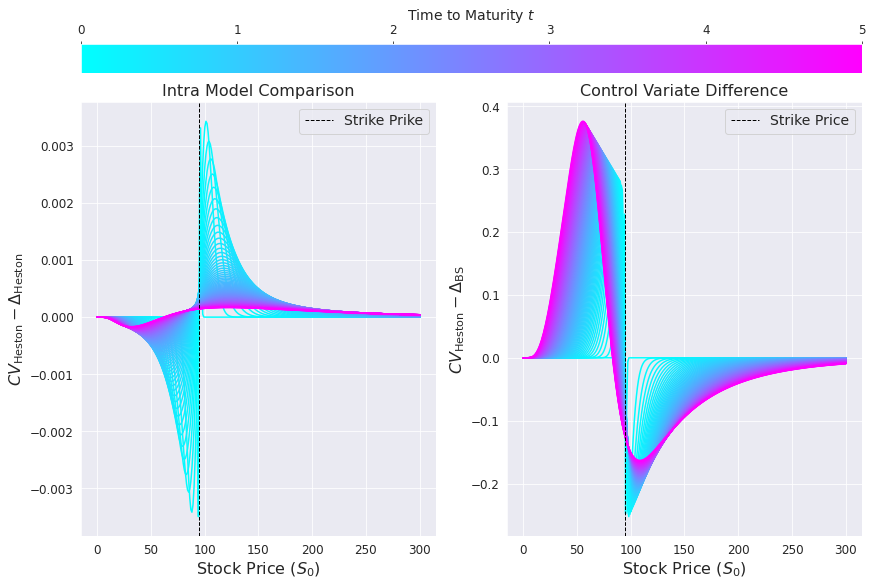

In [23]:
# Compute differences
Dif_C = (Cntr_Var - Delta) 
Dif_D = (Cntr_Var - BS_D)

# Set up figure and axes
fig, (axC, axD) = plt.subplots(1, 2, figsize=(14, 8))
cmap = mpl.cm.get_cmap('cool')
norm_mpl = mpl.colors.Normalize(vmin=0, vmax=np.amax(t), clip=False)

#color code time horizons
for i, ti in enumerate(t):
    color = cmap(norm_mpl(ti))
    axC.plot(S0, Dif_C[i], color=color, linewidth=1.5)
    axD.plot(S0, Dif_D[i], color=color, linewidth=1.5)
axC.axvline(K, color='k', linewidth=1., linestyle="--",label='Strike Prike')
axD.axvline(K, color='k', linewidth=1., linestyle="--",label='Strike Price')
axC.legend(loc='upper right',fontsize=14)
axD.legend(loc='upper right',fontsize=14)

# Style axes
axC.set_xlabel(r'Stock Price ($S_0$)', fontsize=16)
axC.set_ylabel(r'$CV_\mathrm{Heston} - \Delta_\mathrm{Heston}$', fontsize=16)
axC.tick_params(labelsize=12)
axC.set_title("Intra Model Comparison", fontsize=16)

# axD.hlines(y=0, xmin=S0.min(), xmax=S0.max(), color='k', linestyle='--', linewidth=1.5)
axD.set_xlabel(r'Stock Price ($S_0$)', fontsize=16)
axD.set_ylabel(r'$CV_\mathrm{Heston} - \Delta_\mathrm{BS}$', fontsize=16)
axD.tick_params(labelsize=12)
axD.set_title("Control Variate Difference", fontsize=16)

# # Custom colorbar axis above plots
xMinPos = axC.get_position().x0
yMinPos = axC.get_position().y1 + 0.05
xWidth = axD.get_position().x1 - axC.get_position().x0
yWidth = 0.05
cax = fig.add_axes([xMinPos, yMinPos, xWidth, yWidth])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_mpl)
cax.grid(False)
fig.colorbar(sm, cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cax.tick_params(labelsize=12)
cax.set_xlabel(r'Time to Maturity $t$', fontsize=14)

plt.show()

### So, for these parameters, there's not much difference between the Heston full control variate and its Delta

# HEDGING

We note that https://research-api.cbs.dk/ws/portalfiles/portal/92148212/1627284_EHABBthesis.pdf is used a source in construction Heston hedges as well as https://www.researchgate.net/profile/Christopher-Neely-2/publication/228465586_Optimal_Discrete_Hedging_in_the_Heston_Stochastic_Volatility_Model/links/5b195bc7a6fdcca67b636506/Optimal-Discrete-Hedging-in-the-Heston-Stochastic-Volatility-Model.pdf

However, I will not use the descrete time approximations.

### These functions are my own and/or modified from functions.py

In [70]:
def bs_MC_call_fast(S0, K, sigma, t, r, mu = 0, n_sims = 2500, n_hedges = 50):
    
    """Description
    Monte-Carlo simulation of payoffs of delta-hedged call option under Black-Scholes assumptions. 
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (float): volatility
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    
    Return:
    np.array of simulated values of Black-Scholes value of call option with delta-hedging
    """
    
    paths = stock_path_BS(S0, t, r, mu, sigma, n_sims, n_hedges)
    
    #time interval between each step in simulated path
    dt = t/n_hedges

    # Time to maturity at each step
    tArr = np.arange(1, n_hedges+1) * dt  # shape (n_hedges,)

    # Compute deltas for all paths at each time step
    deltas = BS_Delta(paths[:, :-1], K, sigma, tArr, r)
    
    # Stock P&L from delta hedge
    stock_profits_steps = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas * np.exp(-r * tArr)
    stock_profits = np.sum(stock_profits_steps, axis=1)

    # Call payouts
    call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    # Adjusted estimator
    call_payouts_hedged = call_payouts - stock_profits

    return call_payouts_hedged

#In this function, we instead use Delta that comes from directly from the Heston call price 
def heston_call_MC_heston_delta(S0, K, t, r, mu, n_sims, n_hedges, v0, theta, rho, kappa, xi):
    """
    Monte-Carlo Simulation of Call Option under Heston model with Black-Scholes Delta control variates
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_hedges (int): Number of hedges/time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns

    Returns:
    - call_payouts (ndarray): Simulated payouts of a call-option
    """
    
    #NEED TO CHANGE THE NUMBER OF STEPS HERE SOMETHING WRONG WITH SIMULATION
    paths, Vars = stock_path_heston_model(S0, t, r, mu, n_sims, n_hedges, nu_0=v0, theta=theta, rho=rho, kappa=kappa, xi=xi)
    
    dt = t / n_hedges
    # Time to maturity at each step
    tArr = t - np.arange(0, n_hedges) * dt  # shape (n_hedges,)
    
    # New Delta computation
    #works set to -1 uses all available resources for computation
    deltas = Heston_Control_Variant(paths[:,1:],K,tArr,rho,r,v0,xi,kappa,theta,works=-1)

    # Stock P&L from delta hedge
    tArr = np.arange(0, n_hedges) * dt
    stock_profits_steps = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas * np.exp(-r * tArr)
    stock_profits = np.sum(stock_profits_steps, axis=1)

    # Call payouts
    call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    # Adjusted estimator
    call_payouts_hedged = call_payouts - stock_profits
    
    return call_payouts_hedged

## One Option, One Underlying

Let's set the following for our underlying:   
        - $S_0 = 25$ (starting price)   
        - $\mu = 0.05$ (drift of underlying)   
        - $Long\ term\ volatility = 0.3$ ($\sigma$ for Black Scholes, $\sqrt{\theta}$ for Heston)   
        - $t = 1$ (time horizon, in years)   
        - $r = 0.04$ (risk free rate)

And let's consider a strike just barely in the money:   
    - $K = 24$   

In [90]:
S0 = 25
K = 24
mu = 0.0
vol = 0.3
t = 1
r = 0.04
n_sims = 1000
n_hedges = 100

### Black Scholes delta hedging, for comparison

Let's start with 1000 simulations and 100 hedges   
    - n$_{sims} = 1000$   
    - n$_{hedges} = 100$

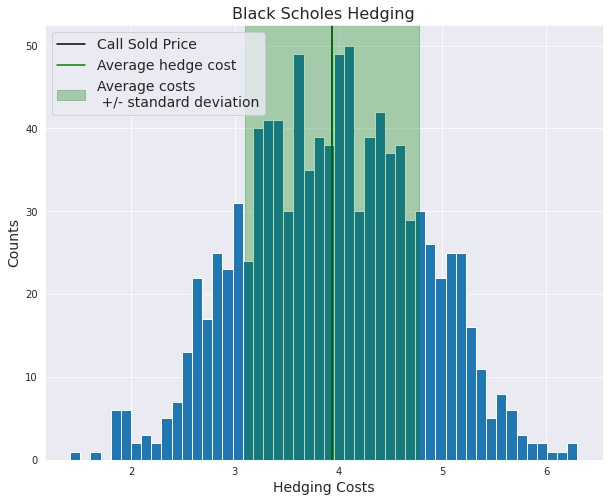

In [91]:
sigma = vol
costs = bs_MC_call_fast(S0, K, sigma, t, r, mu = mu, n_sims = n_sims, n_hedges = n_hedges)
meanCost = np.mean(costs)
stdCosts = np.std(costs)
value_of_call_transaction = BS_Call(S0, K, sigma, t, r)

fig, ax = plt.subplots(figsize = (10,8))
ax.hist(costs,bins=50);
ax.axvline(value_of_call_transaction,color='k',label='Call Sold Price')
ax.axvline(meanCost,color='g',label='Average hedge cost')
ax.axvspan(meanCost-stdCosts, meanCost+stdCosts, alpha=0.3, color='green', label="Average costs\n +/- standard deviation")
ax.legend(loc='best',fontsize=14)
ax.set_xlabel('Hedging Costs', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Black Scholes Hedging', fontsize=16)
plt.show()

### "Delta" (control variate) heding for Heston with Vega sensitivity (see Heston_Control_Variant function)

In [92]:
# Set Heston Parameters
v0 = 0.1
theta = vol*vol
rho = -0.3
kappa = 5
xi = 0.2

### Heston hedging is more intensive due to calculating the integrals, so let's try less hedges

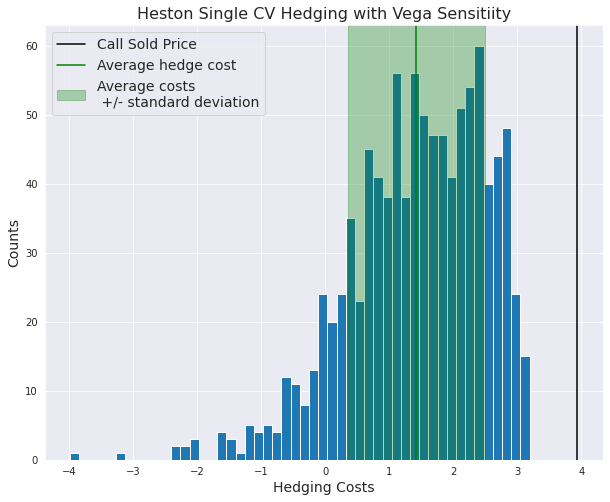

In [93]:
n_hedges = 10
costs = heston_call_MC_heston_delta(S0, K, t, r, mu, n_sims, n_hedges, v0, theta, rho, kappa, xi)
meanCost = np.mean(costs)
stdCosts = np.std(costs)
value_of_call_transaction = BS_Call(S0, K, sigma, t, r)

fig, ax = plt.subplots(figsize = (10,8))
ax.hist(costs,bins=50);
ax.axvline(value_of_call_transaction,color='k',label='Call Sold Price')
ax.axvline(meanCost,color='g',label='Average hedge cost')
ax.axvspan(meanCost-stdCosts, meanCost+stdCosts, alpha=0.3, color='green', label="Average costs\n +/- standard deviation")
ax.legend(loc='best',fontsize=14)
ax.set_xlabel('Hedging Costs', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Heston Single CV Hedging with Vega Sensitiity', fontsize=16)
plt.show()

### Is it a statistical anomaly that hedge on average costs less than the sold price? Let's increase n_hedges back to 100

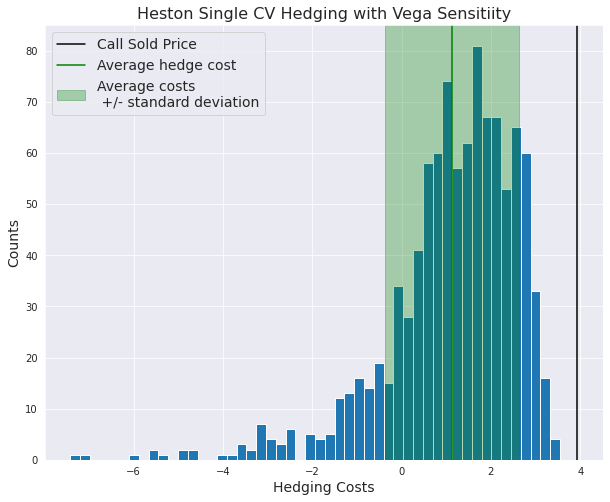

In [94]:
n_hedges = 100
costs = heston_call_MC_heston_delta(S0, K, t, r, mu, n_sims, n_hedges, v0, theta, rho, kappa, xi)
meanCost = np.mean(costs)
stdCosts = np.std(costs)
value_of_call_transaction = BS_Call(S0, K, sigma, t, r)

fig, ax = plt.subplots(figsize = (10,8))
ax.hist(costs,bins=50);
ax.axvline(value_of_call_transaction,color='k',label='Call Sold Price')
ax.axvline(meanCost,color='g',label='Average hedge cost')
ax.axvspan(meanCost-stdCosts, meanCost+stdCosts, alpha=0.3, color='green', label="Average costs\n +/- standard deviation")
ax.legend(loc='best',fontsize=14)
ax.set_xlabel('Hedging Costs', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Heston Single CV Hedging with Vega Sensitiity', fontsize=16)
plt.show()

### The variance got larger and the hedging cost got smaller! Does this trend continue?   
n_hedges = 200

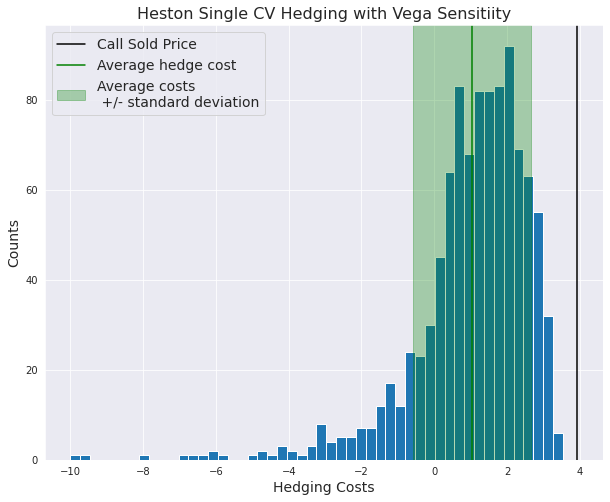

In [95]:
n_hedges = 200
costs = heston_call_MC_heston_delta(S0, K, t, r, mu, n_sims, n_hedges, v0, theta, rho, kappa, xi)
meanCost = np.mean(costs)
stdCosts = np.std(costs)
value_of_call_transaction = BS_Call(S0, K, sigma, t, r)

fig, ax = plt.subplots(figsize = (10,8))
ax.hist(costs,bins=50);
ax.axvline(value_of_call_transaction,color='k',label='Call Sold Price')
ax.axvline(meanCost,color='g',label='Average hedge cost')
ax.axvspan(meanCost-stdCosts, meanCost+stdCosts, alpha=0.3, color='green', label="Average costs\n +/- standard deviation")
ax.legend(loc='best',fontsize=14)
ax.set_xlabel('Hedging Costs', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Heston Single CV Hedging with Vega Sensitiity', fontsize=16)
plt.show()

## So as you continue to hedge more and more, you open yourself up more and more to tails of the distribution!   
## The "fair" selling price of the call is more than the average cost because of *volatility of volatility*   
## This represents unhedgable risk because there is no asset tied to volatility changes!

### ------------------------------------------------------------------------------------------------------------------------------------------

# Finally, we try hedging with TWO calls

In [106]:
def heston_call_MC_heston_delta_vega_2Call(S0, K_tuple, t, r, mu, n_sims, n_hedges, v0, theta, rho, kappa, xi):
    """
    Monte-Carlo Simulation of Call Option under Heston model with TWO control variates
    
    Parameters:
    - S0 (float): Initial stock price
    - K_tuple (float): Strike Prices for Two options, K_1 the sold option, K_2 the dynamic hedging option
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_hedges (int): Number of hedges/time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns

    Returns:
    - call_payouts (ndarray): Simulated payouts of a call-option
    """
    
    #NEED TO CHANGE THE NUMBER OF STEPS HERE SOMETHING WRONG WITH SIMULATION
    paths, Vars = stock_path_heston_model(S0, t, r, mu, n_sims, n_hedges, nu_0=v0, theta=theta, rho=rho, kappa=kappa, xi=xi)
    dt = t / n_hedges
    # Time to maturity at each step
    tArr = t - np.arange(0, n_hedges) * dt  # shape (n_hedges,)

    # Two control variates!
    cv_underlying, cv_call2 = Delta_Vega_2Call_Hedge(paths[:,1:],K_tuple,t,rho,r,nu0,xi,kappa,theta,works=-1)
    K_1, K_2 = K_tuple
    # Stock P&L from delta hedge
    tArr = np.arange(0, n_hedges) * dt
    
    stock_profits_steps = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * cv_underlying * np.exp(-r * tArr)
    stock_profits = np.sum(stock_profits_steps, axis=1)
    
    call2_prices = Heston_Call_Option(paths,K_2,t,rho,r,nu0,xi,kappa,theta,works=-1)
    call2_profits_steps = (call2_prices[:, 1:-1] - np.exp(r*dt)*call2_prices[:, :-2]) * cv_call2[:, :-1] * np.exp(-r * tArr[:-1])

    # Call payouts
    call_payouts = np.maximum(paths[:, -1] - K_1, 0) * np.exp(-r * t)
    
    #Call 2
    call_2_profits = np.sum(call2_profits_steps, axis=1)
    call_2_payouts = cv_call2[:, -1] * np.maximum(paths[:, -1] - K_2, 0) * np.exp(-r * t)

    # Adjusted estimator
    call_payouts_hedged = call_payouts - stock_profits - call_2_profits - call_2_payouts
    
    return call_payouts_hedged

## One more hedging simlation: two control variates, and an extra call bought!

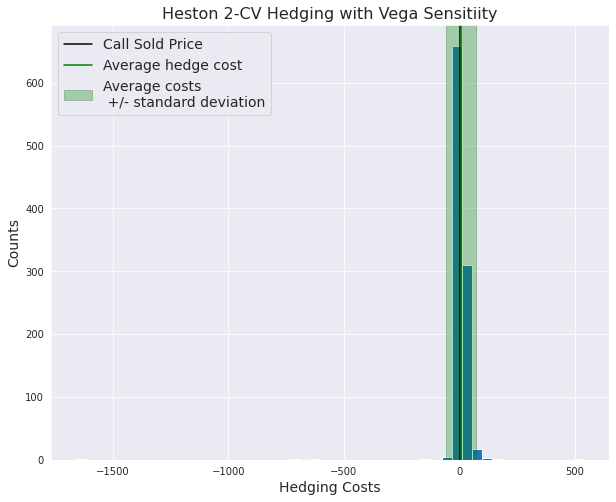

In [115]:
################
n_sims = 1000
n_hedges = 100
################
K_tuple = (K,26)

costs = heston_call_MC_heston_delta_vega_2Call(S0, K_tuple, t, r, mu, n_sims, n_hedges, v0, theta, rho, kappa, xi)
meanCost = np.mean(costs)
stdCosts = np.std(costs)
value_of_call_transaction = BS_Call(S0, K, sigma, t, r)

fig, ax = plt.subplots(figsize = (10,8))
ax.hist(costs,bins=50);
ax.axvline(value_of_call_transaction,color='k',label='Call Sold Price')
ax.axvline(meanCost,color='g',label='Average hedge cost')
ax.axvspan(meanCost-stdCosts, meanCost+stdCosts, alpha=0.3, color='green', label="Average costs\n +/- standard deviation")
ax.legend(loc='best',fontsize=14)
ax.set_xlabel('Hedging Costs', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Heston 2-CV Hedging with Vega Sensitiity', fontsize=16)
plt.show()

### what happens if we discard the five highest and five lowest?

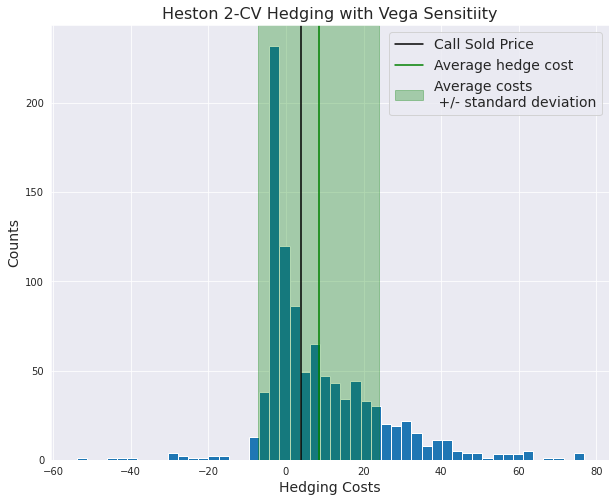

In [123]:
sorted_costs = np.sort(costs)[5:-5]
meanCost = np.mean(sorted_costs)
stdCosts = np.std(sorted_costs)
value_of_call_transaction = BS_Call(S0, K, sigma, t, r)

fig, ax = plt.subplots(figsize = (10,8))
ax.hist(sorted_costs,bins=50);
ax.axvline(value_of_call_transaction,color='k',label='Call Sold Price')
ax.axvline(meanCost,color='g',label='Average hedge cost')
ax.axvspan(meanCost-stdCosts, meanCost+stdCosts, alpha=0.3, color='green', label="Average costs\n +/- standard deviation")
ax.legend(loc='best',fontsize=14)
ax.set_xlabel('Hedging Costs', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Heston 2-CV Hedging with Vega Sensitiity', fontsize=16)
plt.show()

## Looks a bit better but still not great. Maybe not the best hedging strategy!